#Different approaches for Code Smells detection

In [25]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
#!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
#!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
#!git clone https://github.com/bentrevett/code2vec.git

fatal: destination path 'code2vec' already exists and is not an empty directory.


In [1]:
# Import delle librerie necessarie
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
import nltk
import re
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch as pt
from transformers import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, jaccard_score, hamming_loss, f1_score

C:\Users\demai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
path = "../../projects"
projects = []
code_smells = ['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC']
# Itera su tutti i file e le cartelle nella cartella specificata
for item in os.listdir(path):
    # Se l'elemento nella cartella è una cartella, aggiungi il nome alla lista
    if os.path.isdir(os.path.join(path, item)):
       projects.append(item)
    # Stampa la lista di nomi dei progetti
print(projects)

['ant-ivy-2.0.0-alpha2', 'ant-rel-1.8.3', 'cassandra-cassandra-1.0.0', 'elasticsearch-v0.19.0', 'hadoop-release-0.6.0', 'hive-release-0.9.0', 'hsqldb-2.2.8', 'karaf-karaf-2.3.0', 'lucene-releases-lucene-solr-3.6.0', 'manifold-cf-release-0.6', 'nutch-release-1.4', 'pig-release-0.8.0', 'qpid-0.14', 'struts-STRUTS_2_3_4', 'xerces2-j-Xerces-J_2_3_0']


In [10]:
def load_data():
    component = pd.read_csv("../dataset/complete_dataset.csv")
    #component = component.drop(['Project','Version','Smell'],axis=1)
    df = pd.DataFrame()

    path = "../../projects"
    projects = []

    # Itera su tutti i file e le cartelle nella cartella specificata
    for item in os.listdir(path):
        # Se l'elemento nella cartella è una cartella, aggiungi il nome alla lista
        if os.path.isdir(os.path.join(path, item)):
            projects.append(item)
    # Stampa la lista di nomi dei progetti
    print(projects)

    possible_subfolders = ["src/java", "src/main", "src/main/java", "src"]
    #classes = []

    for k in range(len(projects)):
        print(projects[k])
        for i in range(len(component)):
            line = component.loc[i,'ComponentName'].strip()
            line = line.replace(".","/") + ".java"
            for subfolder in possible_subfolders:
                full_path = os.path.join(path, projects[k], subfolder, line)
                if os.path.exists(full_path):
                    with open(full_path, "r", encoding="latin-1") as f:
                        contenuto = f.read()
                    # classes.append(contenuto)
                    temp_df = pd.DataFrame({
                        'Project_name': projects[k],
                        'Component': [contenuto],
                        'CBO' :[component.loc[i,'CBO']],
                        'CYCLO' :[component.loc[i,'CYCLO']],
                        'DIT' :[component.loc[i,'DIT']],
                        'ELOC' :[component.loc[i,'ELOC']],
                        'FanIn' :[component.loc[i,'FanIn']],
                        'FanOut' :[component.loc[i,'FanOut']],
                        'LCOM' :[component.loc[i,'LCOM']],
                        'LOC' :[component.loc[i,'LOC']],
                        'LOCNAMM' :[component.loc[i,'LOCNAMM']],
                        'NOA' :[component.loc[i,'NOA']],
                        'NOC' :[component.loc[i,'NOC']],
                        'NOM' :[component.loc[i,'NOM']],
                        'NOMNAMM' :[component.loc[i,'NOMNAMM']],
                        'NOPA' :[component.loc[i,'NOPA']],
                        'PMMM' :[component.loc[i,'PMMM']],
                        'PRB' :[component.loc[i,'PRB']],
                        'WLOCNAMM' :[component.loc[i,'WLOCNAMM']],
                        'WMC' :[component.loc[i,'WMC']],
                        'NOM' :[component.loc[i,'NOM']],
                        'WMCNAMM': [component.loc[i,'WMCNAMM']],
                        'NMNOPARAM': [component.loc[i,'NMNOPARAM']],
                        'CDSBP': [component.loc[i,'CDSBP']],
                        'CC': [component.loc[i,'CC']],
                        'LC': [component.loc[i,'LC']],
                        'LZC': [component.loc[i,'LZC']],
                        'RB': [component.loc[i,'RB']],
                        'SC': [component.loc[i,'SC']]
                    })
                    df = pd.concat([df, temp_df], ignore_index=True)
                    break # Esci dal ciclo for se hai trovato il file
    return df

In [11]:
df = load_data()

['ant-ivy-2.0.0-alpha2', 'ant-rel-1.8.3', 'cassandra-cassandra-1.0.0', 'elasticsearch-v0.19.0', 'hadoop-release-0.6.0', 'hive-release-0.9.0', 'hsqldb-2.2.8', 'karaf-karaf-2.3.0', 'lucene-releases-lucene-solr-3.6.0', 'manifold-cf-release-0.6', 'nutch-release-1.4', 'pig-release-0.8.0', 'qpid-0.14', 'struts-STRUTS_2_3_4', 'xerces2-j-Xerces-J_2_3_0']
ant-ivy-2.0.0-alpha2
ant-rel-1.8.3
cassandra-cassandra-1.0.0
elasticsearch-v0.19.0
hadoop-release-0.6.0
hive-release-0.9.0
hsqldb-2.2.8
karaf-karaf-2.3.0
lucene-releases-lucene-solr-3.6.0
manifold-cf-release-0.6
nutch-release-1.4
pig-release-0.8.0
qpid-0.14
struts-STRUTS_2_3_4
xerces2-j-Xerces-J_2_3_0


In [12]:
df

,Project_name,Component,CBO,CYCLO,DIT,ELOC,FanIn,FanOut,LCOM,LOC,...,WLOCNAMM,WMC,WMCNAMM,NMNOPARAM,CDSBP,CC,LC,LZC,RB,SC
0,ant-ivy-2.0.0-alpha2,/*\n * Licensed to the Apache Software Founda...,41.0,136.0,1.0,346.0,2036.0,83.0,1482.0,346.0,...,5.592593,136.0,0.0,23.0,0,0,0,0,0,0
1,ant-ivy-2.0.0-alpha2,/*\n * Licensed to the Apache Software Founda...,31.0,172.0,1.0,221.0,0.0,207.0,0.0,221.0,...,3.583333,172.0,0.0,6.0,0,0,0,0,0,0
2,ant-ivy-2.0.0-alpha2,/*\n * Licensed to the Apache Software Founda...,43.0,35.0,1.0,295.0,20.0,121.0,45.0,295.0,...,28.900000,35.0,0.0,2.0,0,0,0,0,0,0
3,ant-ivy-2.0.0-alpha2,/*\n * Licensed to the Apache Software Founda...,8.0,25.0,2.0,59.0,0.0,11.0,0.0,59.0,...,4.363636,25.0,0.0,5.0,0,0,0,0,0,0
4,ant-ivy-2.0.0-alpha2,/*\n * Licensed to the Apache Software Founda...,16.0,26.0,2.0,101.0,2.0,37.0,44.0,101.0,...,8.888889,26.0,0.0,4.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,xerces2-j-Xerces-J_2_3_0,"/*\n * The Apache Software License, Version 1....",4.0,25.0,2.0,55.0,5.0,15.0,28.0,55.0,...,9.375000,25.0,0.0,5.0,0,0,0,0,0,0
8140,xerces2-j-Xerces-J_2_3_0,// XMLFilterImpl.java - base SAX2 filter imple...,14.0,120.0,1.0,449.0,2.0,29.0,364.0,449.0,...,12.548387,120.0,0.0,9.0,0,0,0,0,0,0
8141,xerces2-j-Xerces-J_2_3_0,// XMLReaderAdapter.java - adapt an SAX2 XMLRe...,15.0,45.0,1.0,279.0,2.0,20.0,115.0,279.0,...,9.227273,45.0,0.0,4.0,0,0,0,0,0,0
8142,xerces2-j-Xerces-J_2_3_0,// XMLReaderFactory.java - factory for creatin...,5.0,16.0,1.0,97.0,11.0,12.0,6.0,97.0,...,22.000000,16.0,0.0,2.0,0,0,0,0,0,1


##Data Preparation

###Identification ed elimination of stop words

In [13]:
nltk.download('stopwords')

stop_words = set(stopwords.words('italian'))

def remove_comments(code):
    # Rimuove i commenti su una singola riga
    code = re.sub(r'//.*', '', code)
    # Rimuove i commenti su più righe
    code = re.sub(r'/\*.*?\*/', '', code, flags=re.DOTALL)
    # Rimuove le stopwords
    tokens = [word.lower() for word in code.split() if word.lower() not in stop_words]
    filtered_text = ' '.join(tokens)
    # Rimuoviamo gli import
    code = re.sub(r'import\s+.*?;', '', code, flags=re.DOTALL)
    # Rimuoviamo i package
    code = re.sub(r'package\s+.*?;', '', code, flags=re.DOTALL)
    #Rimuove \n e \t
    code = re.sub(r'[\n\t]', '', code)
    return code

for i in range(len(df)):
    df['Component'][i] = remove_comments(df['Component'][i])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\demai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\demai\AppData\Local\Temp\ipykernel_7828\1156283032.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Component'][i] = remove_comments(df['Component'][i])


####Dataset after the elimination of stop words:

In [14]:
df

,Project_name,Component,CBO,CYCLO,DIT,ELOC,FanIn,FanOut,LCOM,LOC,...,WLOCNAMM,WMC,WMCNAMM,NMNOPARAM,CDSBP,CC,LC,LZC,RB,SC
0,ant-ivy-2.0.0-alpha2,public class Ivy { private static final int...,41.0,136.0,1.0,346.0,2036.0,83.0,1482.0,346.0,...,5.592593,136.0,0.0,23.0,0,0,0,0,0,0
1,ant-ivy-2.0.0-alpha2,public class Ivy14 { privat...,31.0,172.0,1.0,221.0,0.0,207.0,0.0,221.0,...,3.583333,172.0,0.0,6.0,0,0,0,0,0,0
2,ant-ivy-2.0.0-alpha2,public final class Main { private static fi...,43.0,35.0,1.0,295.0,20.0,121.0,45.0,295.0,...,28.900000,35.0,0.0,2.0,0,0,0,0,0,0
3,ant-ivy-2.0.0-alpha2,public class AddPathTask extends Task { pri...,8.0,25.0,2.0,59.0,0.0,11.0,0.0,59.0,...,4.363636,25.0,0.0,5.0,0,0,0,0,0,0
4,ant-ivy-2.0.0-alpha2,public class AntBuildTrigger extends AbstractT...,16.0,26.0,2.0,101.0,2.0,37.0,44.0,101.0,...,8.888889,26.0,0.0,4.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,xerces2-j-Xerces-J_2_3_0,class SecuritySupport12 extends SecuritySuppor...,4.0,25.0,2.0,55.0,5.0,15.0,28.0,55.0,...,9.375000,25.0,0.0,5.0,0,0,0,0,0,0
8140,xerces2-j-Xerces-J_2_3_0,public class XMLFilterImpl implements XMLFi...,14.0,120.0,1.0,449.0,2.0,29.0,364.0,449.0,...,12.548387,120.0,0.0,9.0,0,0,0,0,0,0
8141,xerces2-j-Xerces-J_2_3_0,public class XMLReaderAdapter implements Par...,15.0,45.0,1.0,279.0,2.0,20.0,115.0,279.0,...,9.227273,45.0,0.0,4.0,0,0,0,0,0,0
8142,xerces2-j-Xerces-J_2_3_0,final public class XMLReaderFactory{ pr...,5.0,16.0,1.0,97.0,11.0,12.0,6.0,97.0,...,22.000000,16.0,0.0,2.0,0,0,0,0,0,1


###Data Cleaning
There are NaN (Not a Number) values present, to avoid classification issues, it preferable to remove the instances containing missing data as they are present in small quantities.

In [15]:
df.isnull().sum()

Project_name      0
Component         0
CBO               0
CYCLO             0
DIT               0
ELOC              0
FanIn             0
FanOut            0
LCOM              0
LOC               0
LOCNAMM           0
NOA               0
NOC               0
NOM               0
NOMNAMM           0
NOPA              0
PMMM              0
PRB               0
WLOCNAMM        245
WMC               0
WMCNAMM           0
NMNOPARAM         0
CDSBP             0
CC                0
LC                0
LZC               0
RB                0
SC                0
dtype: int64

In [16]:
df.dropna(inplace=True)

####Dataset after the data cleaning operation:

In [17]:
df.isnull().sum()

Project_name    0
Component       0
CBO             0
CYCLO           0
DIT             0
ELOC            0
FanIn           0
FanOut          0
LCOM            0
LOC             0
LOCNAMM         0
NOA             0
NOC             0
NOM             0
NOMNAMM         0
NOPA            0
PMMM            0
PRB             0
WLOCNAMM        0
WMC             0
WMCNAMM         0
NMNOPARAM       0
CDSBP           0
CC              0
LC              0
LZC             0
RB              0
SC              0
dtype: int64

In [18]:
df

,Project_name,Component,CBO,CYCLO,DIT,ELOC,FanIn,FanOut,LCOM,LOC,...,WLOCNAMM,WMC,WMCNAMM,NMNOPARAM,CDSBP,CC,LC,LZC,RB,SC
0,ant-ivy-2.0.0-alpha2,public class Ivy { private static final int...,41.0,136.0,1.0,346.0,2036.0,83.0,1482.0,346.0,...,5.592593,136.0,0.0,23.0,0,0,0,0,0,0
1,ant-ivy-2.0.0-alpha2,public class Ivy14 { privat...,31.0,172.0,1.0,221.0,0.0,207.0,0.0,221.0,...,3.583333,172.0,0.0,6.0,0,0,0,0,0,0
2,ant-ivy-2.0.0-alpha2,public final class Main { private static fi...,43.0,35.0,1.0,295.0,20.0,121.0,45.0,295.0,...,28.900000,35.0,0.0,2.0,0,0,0,0,0,0
3,ant-ivy-2.0.0-alpha2,public class AddPathTask extends Task { pri...,8.0,25.0,2.0,59.0,0.0,11.0,0.0,59.0,...,4.363636,25.0,0.0,5.0,0,0,0,0,0,0
4,ant-ivy-2.0.0-alpha2,public class AntBuildTrigger extends AbstractT...,16.0,26.0,2.0,101.0,2.0,37.0,44.0,101.0,...,8.888889,26.0,0.0,4.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,xerces2-j-Xerces-J_2_3_0,class SecuritySupport12 extends SecuritySuppor...,4.0,25.0,2.0,55.0,5.0,15.0,28.0,55.0,...,9.375000,25.0,0.0,5.0,0,0,0,0,0,0
8140,xerces2-j-Xerces-J_2_3_0,public class XMLFilterImpl implements XMLFi...,14.0,120.0,1.0,449.0,2.0,29.0,364.0,449.0,...,12.548387,120.0,0.0,9.0,0,0,0,0,0,0
8141,xerces2-j-Xerces-J_2_3_0,public class XMLReaderAdapter implements Par...,15.0,45.0,1.0,279.0,2.0,20.0,115.0,279.0,...,9.227273,45.0,0.0,4.0,0,0,0,0,0,0
8142,xerces2-j-Xerces-J_2_3_0,final public class XMLReaderFactory{ pr...,5.0,16.0,1.0,97.0,11.0,12.0,6.0,97.0,...,22.000000,16.0,0.0,2.0,0,0,0,0,0,1


###Data Balancing

####The dependent variables that the models will need to predict are 6: CDSBP, CC, LC, LZC, RB, SC. Let's analyze the distribution of each label to quantify how balanced the dataset is with the dependent variable.

####Complex Class:

<AxesSubplot: xlabel='CC', ylabel='Count'>

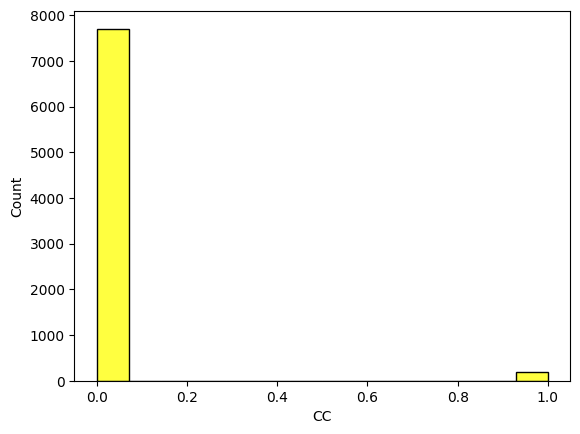

In [19]:
sns.histplot(df['CC'], legend=True, color='yellow')

####Class Data Should Be Private

<AxesSubplot: xlabel='CDSBP', ylabel='Count'>

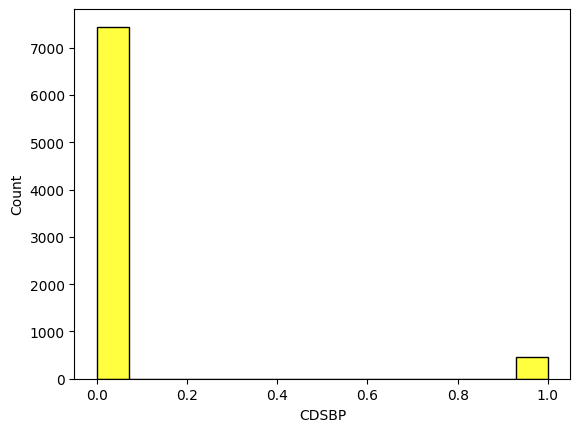

In [20]:
sns.histplot(df['CDSBP'], legend=True, color='yellow')

####Large Class

<AxesSubplot: xlabel='LC', ylabel='Count'>

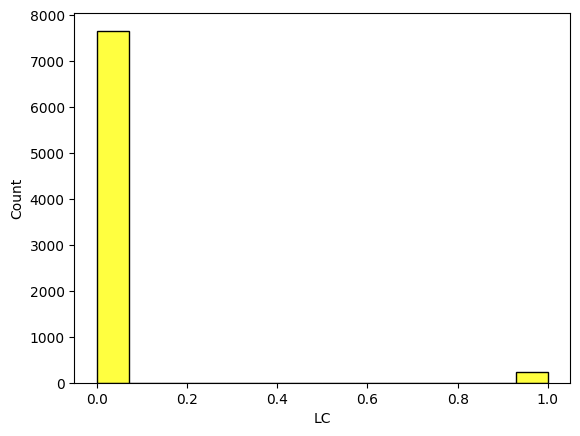

In [21]:
sns.histplot(df['LC'], legend=True, color='yellow')

####Lazy Class

<AxesSubplot: xlabel='LZC', ylabel='Count'>

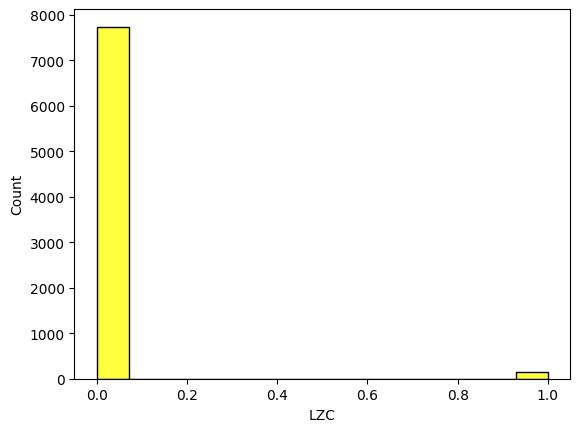

In [22]:
sns.histplot(df['LZC'], legend=True, color='yellow')

####Refused Bequest

<AxesSubplot: xlabel='RB', ylabel='Count'>

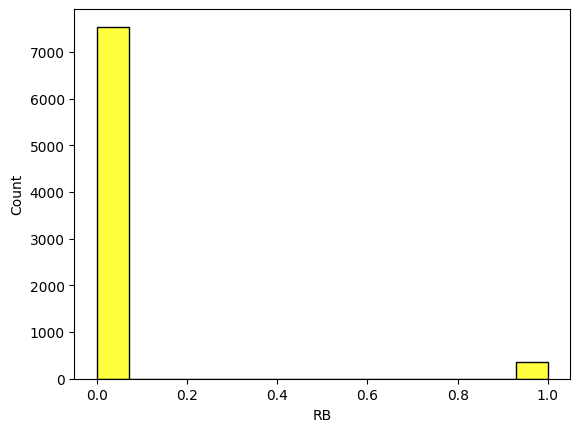

In [23]:
sns.histplot(df['RB'], legend=True, color='yellow')

####Spaghetti Code

<AxesSubplot: xlabel='SC', ylabel='Count'>

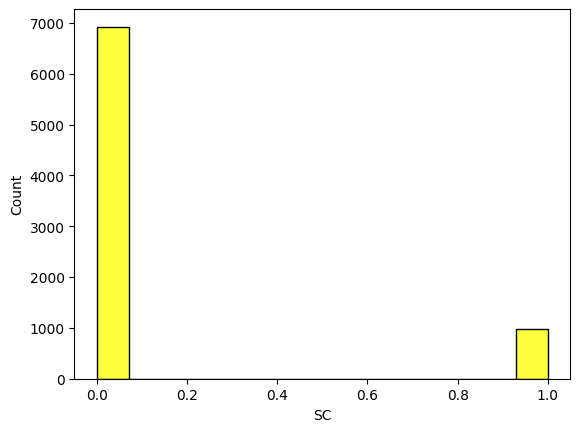

In [24]:
sns.histplot(df['SC'], legend=True, color='yellow')


####The dataset is highly unbalanced, but to avoid the introducing of overfitting or underfitting, after extensive research, it has been decided to avoid the balancing the dataset.

##In this section, will be presented various models, their implementations and the metrics that will be used in the final test to understand which model and which approach works best for identifying code smells.

In [26]:
import torch
code_smells = ['CDSBP', 'CC', 'LC', 'LZC', 'RB', 'SC']
# Dizionario per salvare le predizioni
RF_Trad_predictions = {}
CB_predictions = {}
MLP_predictions = {}

# Dizionario per salvare le metriche
RF_metrics = {}
CB_metrics = {}
MLP_metrics = {}

# Loop attraverso i progetti
for project in projects:
    print("Current project:", project)

    # Caricamento dei dati specifici del progetto
    project_df = df[df['Project_name'] == project]
    if len(project_df) == 0:
            continue

    # Inizializza il dizionari per il progetto corrente
    RF_Trad_predictions[project] = {}
    RF_metrics[project] = {}

    MLP_predictions[project] = {}
    MLP_metrics[project] = {}

    # Loop attraverso i code smell
    for smell in code_smells:
        print("Current code smell:", smell)

        X = project_df.drop(columns=['CDSBP', 'CC', 'LC', 'LC', 'LZC', 'RB', 'SC'])
        y = project_df[str(smell)]

        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=1)

        #Dati per MLP e per CodeBert
        X_train_comp = X_train['Component']
        X_test_comp = X_test['Component']

        X_train.drop(columns=['Component', 'Project_name'], inplace=True)
        X_test.drop(columns=['Component', 'Project_name'], inplace=True)

        normalizer = MinMaxScaler()

        X_train_normalized = normalizer.fit_transform(X_train)
        X_test_normalized = normalizer.transform(X_test)

        # Fitting vari modelli
        # Iniziamo con MLP
        classifier = MLPClassifier(verbose=False, hidden_layer_sizes=[10, 20, 20],activation='logistic')

        # Crea il pipeline
        pipeline = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('classifier', classifier),
        ], verbose=False)

        # Addestra il modello
        pipeline.fit(X_train_comp, Y_train)

        # Valuta il modello
        y_pred_MLP = pipeline.predict(X_test_comp)

        #Metriche per MLP
        precision = precision_score(Y_test, y_pred_MLP, average='macro')
        accuracy = accuracy_score(Y_test, y_pred_MLP)
        mcc = matthews_corrcoef(Y_test, y_pred_MLP)
        recall = recall_score(Y_test, y_pred_MLP, average='macro')
        f1 = f1_score(Y_test, y_pred_MLP, average='macro')

        # Salva le metriche per lo smell corrente nel progetto corrente
        MLP_metrics[project][smell] = {
            "Precision": precision,
            "Accuracy": accuracy,
            "Recall": recall,
            "F1": f1,
            "MCC": mcc
        }

        # Salva le predizioni per lo smell corrente nel progetto corrente
        MLP_predictions[project][smell] = y_pred_MLP

        # RandomForest Tradizionale
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train_normalized, Y_train)
        y_pred = rf.predict(X_test_normalized)

        # Metriche per RandomForest Tradizionale
        precision = precision_score(Y_test, y_pred, average='macro')
        accuracy = accuracy_score(Y_test, y_pred)
        mcc = matthews_corrcoef(Y_test, y_pred)
        recall = recall_score(Y_test, y_pred, average='macro')
        f1 = f1_score(Y_test, y_pred, average='macro')

        # Salva le metriche per lo smell corrente nel progetto corrente
        RF_metrics[project][smell] = {
            "Precision": precision,
            "Accuracy": accuracy,
            "Recall": recall,
            "F1": f1,
            "MCC": mcc
        }

        # Salva le predizioni per lo smell corrente nel progetto corrente
        RF_Trad_predictions[project][smell] = y_pred

        # Caricamento del tokenizer e del modello pre-addestrato CodeBERT
        tokenizer = AutoTokenizer.from_pretrained('microsoft/codebert-base')
        model = AutoModelForSequenceClassification.from_pretrained('microsoft/codebert-base', num_labels=1)

        # Tokenizzazione del set di addestramento
        train_encodings = tokenizer(list(X_train_comp), truncation=True, padding=True, max_length = 512)
        train_labels = pt.tensor(Y_train.values)
        # Tokenizzazione del set di test
        test_encodings = tokenizer(list(X_test_comp), truncation=True, padding=True, max_length = 512)
        test_labels = pt.tensor(Y_test.values)

        # Inizio training


        # Imposta la dimensione del batch desiderata
        batch_size = 8

        # Definizione del dispositivo (GPU o CPU)
        #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        device = torch.device("cpu")

        # Conversione dei dati tokenizzati in tensori PyTorch
        train_inputs = torch.tensor(train_encodings['input_ids']).to(device)
        train_labels = torch.tensor(Y_train.values).unsqueeze(1).to(device)

        val_inputs = torch.tensor(test_encodings['input_ids']).to(device)
        val_labels = torch.tensor(Y_test.values).unsqueeze(1).to(device)

        # Creazione del dataset di addestramento
        train_dataset = TensorDataset(train_inputs, train_labels)

        # Creazione del dataset di validazione
        val_dataset = TensorDataset(val_inputs, val_labels)

        # Crea i dataloader con la nuova batch_size
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

        # Creazione dell'ottimizzatore
        optimizer = AdamW(model.parameters(), lr=1e-5)

        # Definizione della funzione di perdita
        loss_function = loss_function = nn.BCEWithLogitsLoss()

        # Addestramento del modello
        model.to(device)
        model.train()

        for epoch in range(10):
            for batch in train_dataloader:
                optimizer.zero_grad()

                inputs = batch[0].to(device)
                labels = batch[1].to(device)
                labels = labels.float()

                outputs = model(inputs)
                logits = outputs.logits

                loss = loss_function(logits.squeeze(), labels.squeeze())  # Calcola la loss tra logits e etichette
                loss.backward()
                optimizer.step()

                print(f"Epoch {epoch+1} - Loss: {loss.item()}")
                # Libera la memoria GPU
                del inputs, labels
                torch.cuda.empty_cache()

        # Fine training
        for batch in val_dataloader:
          inputs = batch[0].to(device)
          labels = batch[1].to(device)

          val_outputs = model(inputs)
          val_predicted_labels = (val_outputs.logits.sigmoid().squeeze() > 0.5).int()


          # Metriche per CodeBert
          precision = precision_score(labels.cpu().numpy(), val_predicted_labels.cpu().numpy(), average='binary')
          accuracy = accuracy_score(labels.cpu().numpy(), val_predicted_labels.cpu().numpy())
          mcc = matthews_corrcoef(labels.cpu().numpy(), val_predicted_labels.cpu().numpy())
          recall = recall_score(labels.cpu().numpy(), val_predicted_labels.cpu().numpy(), average='binary')
          f1 = f1_score(labels.cpu().numpy(), val_predicted_labels.cpu().numpy(), average='binary')

          # Salva le metriche di CB per lo smell corrente nel progetto corrente
          print(project)
          CB_metrics[project][smell] = {
              "Precision": precision,
              "Accuracy": accuracy,
              "Recall": recall,
              "F1": f1,
              "MCC": mcc
          }

          # Salva le predizioni CB per lo smell corrente nel progetto corrente
          CB_predictions[project][smell] = val_predicted_labels.cpu().numpy()


          # Free up GPU memory
          del inputs, labels, val_outputs, val_predicted_labels
          pt.cuda.empty_cache()



Current project: ant-ivy-2.0.0-alpha2
Current code smell: CDSBP


C:\Users\demai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\demai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of 

In [ ]:
# Stampa le metriche per ogni progetto e smell
for project, smell_metrics in RF_metrics.items():
    print("Project:", project)
    for smell, metric_values in smell_metrics.items():
        print("Code Smell:", smell)
        print(metric_values)
        print("--------------")

In [ ]:
# Stampa le metriche per ogni progetto e smell
for project, smell_metrics in MLP_metrics.items():
    print("Project:", project)
    for smell, metric_values in smell_metrics.items():
        print("Code Smell:", smell)
        print(metric_values)
        print("--------------")

In [ ]:
# Stampa le predizioni per ogni progetto e smell
for project, smell_predictions in MLP_predictions.items():
    print("Project:", project)
    for smell, pred_list in smell_predictions.items():
        print("Code Smell:", smell)
        print(pred_list)
        print("--------------")


In [ ]:
MLP_predictions['ant-ivy-2.0.0-alpha2']['CC']

In [ ]:
MLP_predictions['ant-ivy-2.0.0-alpha2']['LC']

In [ ]:
MLP_predictions['ant-ivy-2.0.0-alpha2']['LZC']

In [ ]:
MLP_predictions['ant-ivy-2.0.0-alpha2']['CDSBP']

In [ ]:
MLP_predictions['ant-ivy-2.0.0-alpha2']['RB']

In [ ]:
MLP_predictions['ant-ivy-2.0.0-alpha2']['SC']

In [ ]:
MLP_metrics['ant-ivy-2.0.0-alpha2']['SC']

In [ ]:
MLP_metrics['ant-ivy-2.0.0-alpha2']['CDSBP']